<a href="https://colab.research.google.com/github/komisarzGiT/gai/blob/main/UG_ML02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Marcin Byra  
Class: 2526-1MAO2  
Student ID: 25258161

Assignment 2  
Classification of Seizure using Machine Learning Classifiers and EEG Data

The objective is to
Cardiac Health Records

In [41]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE

In [42]:
#Cardiac Health Records
cardiac_data = 'https://raw.githubusercontent.com/komisarzGiT/gai/refs/heads/main/GU_ML01/Assignment2/Modified_Heart_failure_data.csv'

df_cardiac_data = pd.read_csv(cardiac_data)

#no split into train and test sets
#there are no know labels and objective is not prediction but categorization

#check data types
print(f"Data types \n{df_cardiac_data.dtypes}")

Data types 
age                         float64
anaemia                     float64
creatinine_phosphokinase    float64
diabetes                    float64
ejection_fraction           float64
high_blood_pressure         float64
platelets                   float64
serum_creatinine            float64
serum_sodium                float64
sex                         float64
smoking                     float64
time                        float64
patient_id                    int64
dtype: object


In [43]:
cardiac_rows, cardiac_columns = df_cardiac_data.shape
print(f"Cardiac health data set has {cardiac_rows} observations and {cardiac_columns} variables. Sample data:")
display(df_cardiac_data.head(3))

Cardiac health data set has 299 observations and 13 variables. Sample data:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,patient_id
0,75.0,0.0,582.0,0.0,20.0,1.0,265000.00,1.9,130.0,1.0,0.0,4.0,0
1,55.0,0.0,7861.0,0.0,38.0,0.0,263358.03,1.1,136.0,1.0,0.0,6.0,1
2,65.0,NaN,146.0,0.0,20.0,0.0,162000.00,1.3,129.0,1.0,NaN,7.0,2


NEED TO Fill gaps sing all available data ensures the discovered clusters (the patient profiles) are the most representative and stable for the entire population being studied.

In [44]:
missing_values = df_cardiac_data.isnull().sum()
print("Missing Values\n", missing_values)

Missing Values
 age                         29
anaemia                     29
creatinine_phosphokinase    29
diabetes                    29
ejection_fraction           29
high_blood_pressure         29
platelets                   29
serum_creatinine            29
serum_sodium                29
sex                         29
smoking                     29
time                        29
patient_id                   0
dtype: int64


In [45]:
#To fill missing values, distinguish between categorical binary and continous variables.
#Visual data inspection as well as count of valeus cna help here

unique_counts = df_cardiac_data.nunique()
print(unique_counts)

age                          47
anaemia                       2
creatinine_phosphokinase    193
diabetes                      2
ejection_fraction            16
high_blood_pressure           2
platelets                   161
serum_creatinine             37
serum_sodium                 23
sex                           2
smoking                       2
time                        141
patient_id                  299
dtype: int64


In [46]:
# Binary (mode imputation)

binary_cols = [ 'anaemia', 'diabetes', 'high_blood_pressure',
    'sex', 'smoking' ]

# Continuous (median imputation)
continuous_cols = [ 'age', 'creatinine_phosphokinase', 'ejection_fraction',
    'platelets', 'serum_creatinine', 'serum_sodium', 'time' ]

from sklearn.impute import SimpleImputer

# remove patient ID for all further processing; not relevant for clustering
df_cardiac_fill = df_cardiac_data.drop('patient_id', axis=1)


# Impute Continuous Columns with the Median
# The median is robust to outliers, which is crucial for features like CPK and Platelets.
imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
df_cardiac_fill[continuous_cols] = imputer_median.fit_transform(df_cardiac_fill[continuous_cols])

# --- 3. Impute Binary/Categorical Columns with the Mode (Most Frequent) ---
# The mode preserves the discrete nature of these indicator variables (0 or 1).
imputer_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_cardiac_fill[binary_cols] = imputer_mode.fit_transform(df_cardiac_fill[binary_cols])

# Convert binary/categorical columns to integer type
for col in binary_cols:
    df_cardiac_fill[col] = df_cardiac_fill[col].astype(int)

# Check for remaining missing values to confirm imputation success
print(df_cardiac_fill.isnull().sum())

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
dtype: int64


In [47]:
#To understand which features are most likely to be influential during the preprocessing step,
#before running any clustering algorithm. The most robust method for this is Principal Component Analysis (PCA).
#PCA is a dimensionality reduction technique that finds the directions (components)
# in your scaled data that capture the maximum amount of variance. The features that contribute most to these high-variance directions are inherently the most important for defining the dataset's structure.


# Scale the data (Crucial step for PCA)
scaler = StandardScaler()

X_cardiac_scaled = scaler.fit_transform(df_cardiac_fill) #X since it returns np.array

#PCA

# Initialize PCA to reduce the 11 features to 2 components (PC1 and PC2)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_cardiac_scaled)

# Create a DataFrame for the PCA results
df_cardiac_pca2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
# The original 'feature_names' were incorrect here, as they referred to the PCA result columns.
# The index for loadings should be the original feature names from df_cardiac_fill.

print("--- PCA Explained Variance Ratio ---")
print(f"PC1 explains: {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"PC2 explains: {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"Total variance explained by 2 components: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.2f}%")

print("\n--- PCA Transformed Data Head ---")
print(df_cardiac_pca2.head())

# Fix: Use the original column names from df_cardiac_fill as the index for the loadings DataFrame
print(df_cardiac_fill.columns)
loadings_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df_cardiac_fill.columns)
display(loadings_df)

--- PCA Explained Variance Ratio ---
PC1 explains: 13.28% of variance
PC2 explains: 12.21% of variance
Total variance explained by 2 components: 25.49%

--- PCA Transformed Data Head ---
        PC1       PC2
0  0.410840 -2.658527
1  2.455400  0.725972
2  1.081660 -2.267475
3  0.007465 -1.206092
4 -0.862545 -4.215684
Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')


,PC1,PC2
age,-0.091808,-0.416441
anaemia,-0.415135,-0.246599
creatinine_phosphokinase,0.247574,0.143837
diabetes,-0.081168,0.018772
ejection_fraction,-0.267044,0.260671
high_blood_pressure,-0.254858,-0.013317
platelets,-0.104631,0.143586
serum_creatinine,-0.004994,-0.475510
serum_sodium,-0.142739,0.420485
sex,0.562540,-0.154153


Why Standardization is Essential for Clustering
1. Eliminating Scale Bias in Distance Metrics

features with larger magnitudes will disproportionately dominate the distance calculation, leading to a phenomenon known as Scale Bias
creatinine_phosphokinase (CPK) values can reach into the thousands (e.g., $7861.0$), while age is in the 50–90 range, and serum_creatinine is typically under $3.0$.

By ensuring all features have the same variance and scale, the Standardization process guarantees that:

Equal Contribution: Every feature contributes equally to the distance calculation, regardless of its original units or magnitude.

Accurate Proximity: The proximity between patients is defined by their relative differences (in terms of standard deviations from the mean), which accurately reflects the inherent structure of the data rather than being an artifact of the measurement units.

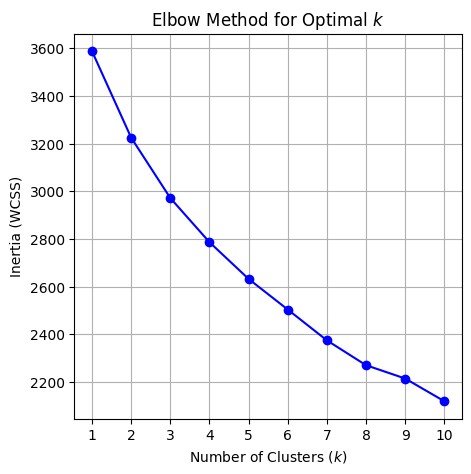

In [48]:
#  Determining Optimal k (Elbow Method) ---
inertia = []
K_range = range(1, 11)

for k in K_range:
    # Set n_init=10 for robustness
    # use k-means++ for probabilistic centroid placement
    # repat 10 times, take highest inertia
    kmeans_elbow = KMeans(n_clusters=k, random_state=13, init='k-means++', n_init=10)
    kmeans_elbow.fit(X_cardiac_scaled)
    inertia.append(kmeans_elbow.inertia_)


# Plot the Elbow Curve
plt.figure(figsize=(5, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method for Optimal $k$')
plt.xlabel('Number of Clusters ($k$)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(K_range)
plt.grid(True)
plt.savefig("elbow_method.png")
plt.show()


In [49]:
# Create a DataFrame for inertia and K_range
elbow_data = pd.DataFrame({
    'Number of Clusters (k)': K_range,
    'Inertia': inertia
})

# Calculate the decrease in inertia from the previous k
elbow_data['Inertia Decrease'] = elbow_data['Inertia'].diff().abs().round(0)

print("Elbow Method Data (Inertia and Decrease):")
display(elbow_data)

Elbow Method Data (Inertia and Decrease):


,Number of Clusters (k),Inertia,Inertia Decrease
0,1,3588.000000,NaN
1,2,3225.231266,363.0
2,3,2971.941516,253.0
3,4,2786.672195,185.0
4,5,2632.410376,154.0
5,6,2503.989754,128.0
6,7,2374.595219,129.0
7,8,2270.330850,104.0
8,9,2214.441252,56.0
9,10,2119.145729,95.0


In [50]:
# --- 3. Apply Clustering Algorithms (k=3 Chosen) ---
k_clusters = 3

# Create a DataFrame for storing cluster results, starting from DF without patient ID
df_cardiac_scaled = df_cardiac_fill.copy()

# K-Means Clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=13, n_init=10)
df_cardiac_scaled['KMeans_Cluster'] = kmeans.fit_predict(X_cardiac_scaled)

# Hierarchical Clustering (Agglomerative)
# defaulting to Ward's Linkage to
# At every step of the Agglomerative process, the algorithm looks at all
# possible pairs of clusters and merges the pair that has the smallest linkage
# distance. Ward's Linkage defines the distance between two clusters as the
# increase in the total within-cluster sum of squares (WCSS) that results from
# merging them
# It prefers merging clusters that lead to the smallest overall increase in heterogeneity
#deterministic and initialization-free.
#No Random Start: Agglomerative Clustering starts with every single data point as its own cluster. There is no random guessing of centroids involved.
# Fixed Merging: The algorithm proceeds by consistently merging the two closest
#clusters at each step according to a fixed linkage criterion (e.g., Ward, Average, Complete). The sequence of mergers is solely determined by the fixed distances between the data points.

agglo = AgglomerativeClustering(n_clusters=k_clusters)
df_cardiac_scaled['Agglo_Cluster'] = agglo.fit_predict(X_cardiac_scaled)

print(df_cardiac_scaled)

      age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0        0                     582.0         0               20.0   
1    55.0        0                    7861.0         0               38.0   
2    65.0        0                     146.0         0               20.0   
3    50.0        1                     111.0         0               20.0   
4    65.0        1                     160.0         1               20.0   
..    ...      ...                       ...       ...                ...   
294  62.0        0                      61.0         1               38.0   
295  55.0        0                    1820.0         0               38.0   
296  45.0        0                    2060.0         1               60.0   
297  45.0        0                     250.0         0               38.0   
298  50.0        0                     196.0         0               45.0   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \

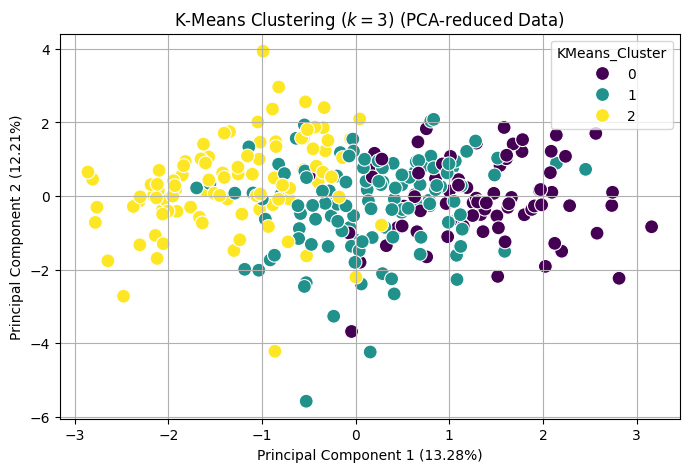

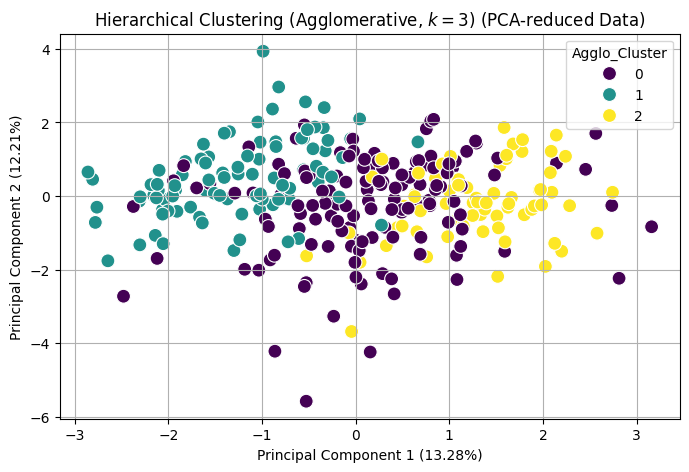

In [51]:
# --- 3. Dimensionality Reduction (PCA) for Visualization ---
# Reduce 11 features to 2 principal components (PC1 and PC2)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_cardiac_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['KMeans_Cluster'] = df_cardiac_scaled['KMeans_Cluster']
pca_df['Agglo_Cluster'] = df_cardiac_scaled['Agglo_Cluster']


# --- 4. Cluster Visualization Function and Execution ---
def plot_clusters(df_pca, cluster_col, title, filename, pca_obj):
    """Generates and saves a scatter plot of the clusters on the PCA-reduced data."""
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x='PC1',
        y='PC2',
        hue=cluster_col,
        data=df_pca,
        palette='viridis',
        legend='full',
        s=100
    )
    plt.title(f'{title} (PCA-reduced Data)')
    plt.xlabel(f'Principal Component 1 ({pca_obj.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'Principal Component 2 ({pca_obj.explained_variance_ratio_[1]*100:.2f}%)')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Plot K-Means Clusters
plot_clusters(
    pca_df,
    'KMeans_Cluster',
    'K-Means Clustering ($k=3$)',
    'kmeans_clusters_pca.png',
    pca
)

# Plot Hierarchical Clusters
plot_clusters(
    pca_df,
    'Agglo_Cluster',
    'Hierarchical Clustering (Agglomerative, $k=3$)',
    'agglo_clusters_pca.png',
    pca
)

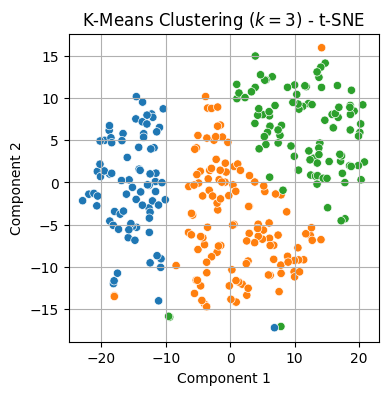

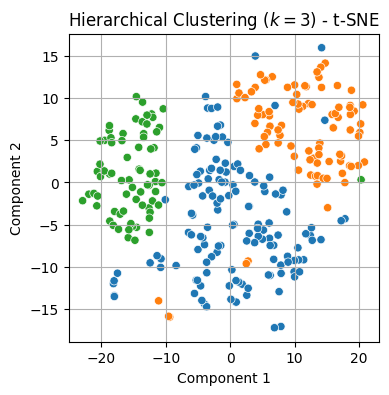

In [79]:
# --- 3. Apply t-SNE for Visualization ---
# tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate='auto', init='pca')
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(X_cardiac_scaled)
tsne_df = pd.DataFrame(data = tsne_components, columns = ['Component 1', 'Component 2'])
tsne_df['KMeans_Cluster'] = df_cardiac_scaled['KMeans_Cluster']
tsne_df['Agglo_Cluster'] = df_cardiac_scaled['Agglo_Cluster']


# --- 4. Cluster Visualization Code (no saving) ---
def plot_clusters_tsne(df_tsne, cluster_col, title):
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x='Component 1',
        y='Component 2',
        hue=cluster_col,
        data=df_tsne,
        palette = 'tab10',
        legend = False,
    )
    plt.title(f'{title}')
    # plt.xlabel('Component 1')
    # plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# K-Means Plot
plot_clusters_tsne(
    tsne_df,
    'KMeans_Cluster',
    'K-Means Clustering ($k=3$) - t-SNE'
)

# Hierarchical Plot
plot_clusters_tsne(
    tsne_df,
    'Agglo_Cluster',
    'Hierarchical Clustering ($k=3$) - t-SNE'
)

In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

# --- 1. Data Preparation (Load, Impute, Scale) ---
# [Steps to load data and create X_scaled matrix are performed here]

# # --- 2. Apply Clustering Algorithms (k=3) ---
# k_clusters = 3

# # K-Means Clustering
# kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
# y_kmeans = kmeans.fit_predict(X_scaled)

# # Hierarchical Clustering (Agglomerative)
# agglo = AgglomerativeClustering(n_clusters=k_clusters)
# y_agglo = agglo.fit_predict(X_scaled)

# # --- 3. Calculate Evaluation Metrics ---

# Silhouette Score (measures how similar an object is to its own cluster vs. other clusters)
silhouette_kmeans = silhouette_score(X_cardiac_scaled, y_kmeans)
silhouette_agglo = silhouette_score(X_cardiac_scaled, y_agglo)

# Davies-Bouldin Index (measures the average similarity ratio of each cluster with its most similar cluster)
dbi_kmeans = davies_bouldin_score(X_cardiac_scaled, y_kmeans)
dbi_agglo = davies_bouldin_score(X_cardiac_scaled, y_agglo)

# Adjusted Rand Index (measures the similarity between the two partitioning methods)
ari_score = adjusted_rand_score(y_kmeans, y_agglo)

# --- 4. Prepare Output Table ---
metrics_summary = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index (DBI)', 'Adjusted Rand Index (ARI)'],
    'K-Means (k=3)': [silhouette_kmeans, dbi_kmeans, ari_score],
    'Hierarchical (k=3)': [silhouette_agglo, dbi_agglo, 'N/A'] # ARI is comparison, not an individual metric
}).set_index('Metric')

print("--- Cluster Evaluation Metrics (k=3) ---")
print(metrics_summary.to_markdown(numalign="left", stralign="left", floatfmt=".4f"))

NameError: name 'X_scaled' is not defined